<a href="https://colab.research.google.com/github/GerardoFesta/3DFER_SE4AI/blob/1-poor-performances-on-test-set/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn

In [2]:
%matplotlib inline
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow

TRAIN_PATH = "train"
TEST_PATH ="test"


In [ ]:
import os 
from google.colab import drive
drive.mount("/content/drive")

MessageError: ignored

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#Questo commento serve per provare il funzionamento dei commit con colab

batch_size = 1024 

In [4]:
import zipfile


zip_ref = zipfile.ZipFile('fer2013.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall() #Extracts the files into the /tmp folder
zip_ref.close()

In [14]:
import os
class_dir=os.listdir(TRAIN_PATH+'/')
folder_names = class_dir
label_dict = {folder_names[i]:i for i in range(len(folder_names))}
num_classes=len(label_dict)
train_image_filenames = []
train_labels = []

# iterate through each folder and collect filenames and labels
for folder_name in folder_names:
    folder_path = os.path.join(TRAIN_PATH, folder_name)
    for filename in os.listdir(folder_path):
        train_image_filenames.append(os.path.join(TRAIN_PATH+"/"+folder_name, filename))
        train_labels.append(label_dict[folder_name])

# create pandas dataframe
train_df = pd.DataFrame({'filename': train_image_filenames, 'emotion': train_labels})

print(len(train_df))


test_image_filenames = []
test_labels = []
class_dir=os.listdir(TEST_PATH+'/')
for folder_name in folder_names:
    folder_path = os.path.join(TEST_PATH, folder_name)
    for filename in os.listdir(folder_path):
        test_image_filenames.append(os.path.join(TEST_PATH+"/"+folder_name, filename))
        test_labels.append(label_dict[folder_name])

test_df = pd.DataFrame({'filename': test_image_filenames, 'emotion': test_labels})

28709


In [15]:
train_df['img_as_matrix'] = train_df['filename'].apply(lambda path: cv2.imread(path))
test_df['img_as_matrix'] = test_df['filename'].apply(lambda path: cv2.imread(path))


In [7]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data.iloc[index]['img_as_matrix'] 
        label = self.data.iloc[index]['emotion'] 

        # Esegui le trasformazioni se definite
        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [16]:
train_df.drop(columns=["filename"], inplace=True)
test_df.drop(columns=["filename"], inplace=True)
train_df.at[0,"img_as_matrix"]
full_df = pd.concat([train_df, test_df])

full_dataset = CustomDataset(full_df, transform=transforms.ToTensor())
full_daset_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)



#train_dataset = CustomDataset(train_df, transform=transforms.ToTensor())
#test_dataset = CustomDataset(test_df, transform=transforms.ToTensor())
 

#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X_train, X_test, y_train, y_test = train_test_split(full_df['img_as_matrix'], full_df['emotion'], test_size=0.33, random_state=42, stratify=full_df['emotion'])

print(type(X_train))
def mean_std_calc(loader):
  cnt = 0
  fst_moment = torch.empty(3)
  snd_moment = torch.empty(3)

  for images, _ in loader:
      b, c, h, w = images.shape
      nb_pixels = b * h * w
      sum_ = torch.sum(images, dim=[0, 2, 3])
      sum_of_square = torch.sum(images ** 2,
                                dim=[0, 2, 3])
      fst_moment = (cnt * fst_moment + sum_) / (
                    cnt + nb_pixels)
      snd_moment = (cnt * snd_moment + sum_of_square) / (
                          cnt + nb_pixels)
      cnt += nb_pixels

  mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)
  return mean, std

#Normalizzazione train loader
mean, std = mean_std_calc(full_daset_loader)

transform_img_normal = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std= std),
])

X_train.name="img_as_matrix"
X_test.name="img_as_matrix"
y_test.name="emotion"
y_train.name="emotion"
new_train_df=pd.concat([X_train, y_train], axis=1)
new_test_df=pd.concat([X_test, y_test], axis=1)
print(new_train_df)

train_dataset = CustomDataset(new_train_df, transform=transform_img_normal)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


test_dataset = CustomDataset(new_test_df, transform=transform_img_normal)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



<class 'pandas.core.series.Series'>
                                           img_as_matrix  emotion
5183   [[[87, 87, 87], [50, 50, 50], [97, 97, 97], [1...        1
7982   [[[101, 101, 101], [87, 87, 87], [65, 65, 65],...        1
25179  [[[61, 61, 61], [89, 89, 89], [89, 89, 89], [8...        6
25663  [[[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], ...        6
3466   [[[140, 140, 140], [143, 143, 143], [142, 142,...        2
...                                                  ...      ...
25809  [[[13, 13, 13], [14, 14, 14], [18, 18, 18], [1...        6
16771  [[[56, 56, 56], [67, 67, 67], [91, 91, 91], [7...        3
5710   [[[47, 47, 47], [28, 28, 28], [50, 50, 50], [3...        4
15307  [[[141, 141, 141], [142, 142, 142], [140, 140,...        2
26086  [[[164, 164, 164], [177, 177, 177], [178, 178,...        6

[24044 rows x 2 columns]


In [9]:
def accuracy(preds, labels):
  probabilities = torch.nn.functional.softmax(preds, dim=1)
  _, predicted = torch.max(probabilities, dim=1)
  n_correct = (predicted==labels).sum().float()

  acc =n_correct / labels.shape[0]
  acc= torch.round(acc*100)
  return acc, n_correct;

# Resnet 50 Pytorch Code

In [10]:
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels,
            intermediate_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512 * 4, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)        
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = self.bn2(x)
        x = self.fc2(x)
        x = self.bn3(x)
        x = self.fc3(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


def ResNet50(img_channel=3, num_classes=7):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)



In [17]:
model = ResNet50().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [18]:
n_total_steps = len(train_loader)
num_epochs = 20
acc_list_train=[]
acc_list_test=[]
for epoch in range(num_epochs):

    running_loss = 0.0
    running_acc = 0.0

    for i, (images, labels) in enumerate(train_loader):
       
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)

      loss = criterion(outputs, labels)
      

      acc, _ = accuracy(outputs, labels)

      optimizer.zero_grad()      
      loss.backward()            
      optimizer.step()  
      running_loss += loss.item()    
      running_acc += acc.item()

    print (f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Acc: {running_acc/len(train_loader):.4f}')
    acc_list_train.append(running_acc/len(train_loader))
    tot_corrette = 0
    tot_eseguite = 0
    with torch.no_grad():

      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
        
          outputs = model(images)
          _, n_corrette=accuracy(outputs, labels)
          
          tot_corrette+=n_corrette.item()
          tot_eseguite+=labels.shape[0]
      test_acc=100* (tot_corrette/tot_eseguite)
      acc_list_test.append(test_acc)
      print("Test acc: ", test_acc)


print('Finished Training')

PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Epoch [0/20], Loss: 1.9889, Acc: 16.6250
Test acc:  18.846576036477245
Epoch [1/20], Loss: 1.9295, Acc: 20.6667
Test acc:  22.11432913957612
Epoch [2/20], Loss: 1.8994, Acc: 23.8750
Test acc:  24.66435869289876
Epoch [3/20], Loss: 1.8690, Acc: 26.6250
Test acc:  26.15046863125897
Epoch [4/20], Loss: 1.8401, Acc: 28.3750
Test acc:  27.813898505446254
Epoch [5/20], Loss: 1.8120, Acc: 30.0417
Test acc:  29.561766444313097
Epoch [6/20], Loss: 1.7634, Acc: 32.6667
Test acc:  31.647386641898166
Epoch [7/20], Loss: 1.7028, Acc: 34.9583
Test acc:  33.22637845140589
Epoch [8/20], Loss: 1.6437, Acc: 38.1250
Test acc:  34.256522840496494
Epoch [9/20], Loss: 1.5820, Acc: 40.7083
Test acc:  35.60753187536942
Epoch [10/20], Loss: 1.5174, Acc: 43.9583
Test acc:  36.61234484505615
Epoch [11/20], Loss: 1.4463, Acc: 46.6667
Test acc:  36.66300768386389
Epoch [12/20], Loss: 1.3828, Acc: 49.7500
Test acc:  37.01764755551803
Epoch [13/20], Loss: 1.2913, Acc: 53.2917
Test acc:  37.135860846069406
Epoch [14/

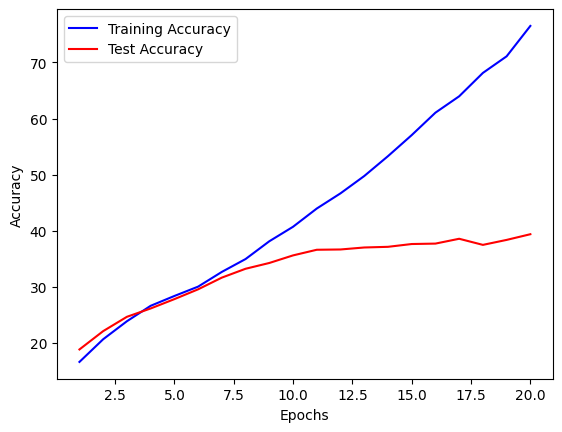

In [19]:

# Creazione dell'asse x con gli indici delle liste
epochs = range(1, len(acc_list_train) + 1)

# Tracciamento delle due variabili come linee di colori diversi
plt.plot(epochs, acc_list_train, 'b', label='Training Accuracy')
plt.plot(epochs, acc_list_test, 'r', label='Test Accuracy')

# Titoli degli assi
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Aggiunta di una legenda
plt.legend()

# Visualizzazione del grafico
plt.show()

In [67]:
with torch.no_grad():
    tot_corrette = 0
    tot_eseguite = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
       
        outputs = model(images)
        _, n_corrette=accuracy(outputs, labels)
        tot_corrette+=n_corrette
        tot_eseguite+=labels.shape[0]

ACC ON TEST SET:  tensor(38., device='cuda:0')
ACC ON TEST SET:  tensor(40., device='cuda:0')
ACC ON TEST SET:  tensor(39., device='cuda:0')
ACC ON TEST SET:  tensor(38., device='cuda:0')
ACC ON TEST SET:  tensor(40., device='cuda:0')
ACC ON TEST SET:  tensor(40., device='cuda:0')
ACC ON TEST SET:  tensor(43., device='cuda:0')
ACC ON TEST SET:  tensor(40., device='cuda:0')
ACC ON TEST SET:  tensor(38., device='cuda:0')
ACC ON TEST SET:  tensor(37., device='cuda:0')
ACC ON TEST SET:  tensor(40., device='cuda:0')
ACC ON TEST SET:  tensor(38., device='cuda:0')
